In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cartopy
import cartopy.crs as ccrs
import matplotlib
%matplotlib inline
from netCDF4 import Dataset


import iris
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.colors as colors
from sklearn import datasets
import iris.analysis
import numpy.ma as ma

import matplotlib.ticker as mticker
from matplotlib.ticker import MultipleLocator
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point


from iris.experimental.regrid import regrid_weighted_curvilinear_to_rectilinear

import matplotlib.cm as mpl_cm
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.pyplot import xcorr


from scipy.interpolate import splrep, splev
from scipy.stats import pearsonr
from scipy import signal 

import math
from matplotlib import mlab

import warnings
warnings.filterwarnings("ignore")

## apply low-pass filter to amoc & tas/sst timeseries in mh & pi

In [2]:
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.

    Args:

    window: int
        The length of the filter window. (i.e., the number of coefficients). window_length must be a positive odd integer.

    cutoff: float
        The cutoff frequency in inverse time steps.

    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]


In [2]:
cube_ccsm_amoc = iris.load_cube('CCSM4_midHolocene.cvdp_data.1000-1300.nc', 'amoc_timeseries_ann')

# CESM model: ValueError: Missing data dimensions for multi-valued DimCoord 'time'
#cube_cesm_amoc = iris.load_cube('CESM2_midHolocene.cvdp_data.1-700.nc', 'amoc_timeseries_ann')

cube_ec_amoc = iris.load_cube('EC-Earth3-LR_midHolocene.cvdp_data.2245-2445.nc', 'amoc_timeseries_ann')

cube_fgoalsg2_amoc = iris.load_cube('FGOALS-g2_midHolocene.cvdp_data.340-1019.nc', 'amoc_timeseries_ann')

cube_giss_amoc = iris.load_cube('GISS-E2-1-G_midHolocene.cvdp_data.2900-2999.nc', 'amoc_timeseries_ann')

cube_hadgem_amoc = iris.load_cube('HadGEM3-GC31-LL_midHolocene.cvdp_data.2250-2349.nc', 'amoc_timeseries_ann')

cube_inm_amoc = iris.load_cube('INM-CM4-8_midHolocene.cvdp_data.1880-2079.nc', 'amoc_timeseries_ann')

cube_ipsl_amoc = iris.load_cube('IPSL-CM6A-LR_midHolocene.cvdp_data.1850-2399.nc', 'amoc_timeseries_ann')

cube_mpi2_amoc = iris.load_cube('MPI-ESM1-2-LR_midHolocene.cvdp_data.1001-1500.nc', 'amoc_timeseries_ann')

cube_mri_amoc = iris.load_cube('MRI-ESM2-0_midHolocene.cvdp_data.1951-2150.nc', 'amoc_timeseries_ann')

cube_mpip_amoc = iris.load_cube('MPI-ESM-P_midHolocene.cvdp_data.1850-1949.nc', 'amoc_timeseries_ann')

cube_mri3_amoc = iris.load_cube('MRI-CGCM3_midHolocene.cvdp_data.1951-2050.nc', 'amoc_timeseries_ann')

cube_noresm2_amoc = iris.load_cube('NorESM2-LM_midHolocene.cvdp_data.2101-2200.nc', 'amoc_timeseries_ann')


In [4]:
cube_amoc_ann=[cube_ccsm_amoc,  cube_ec_amoc, 
                cube_fgoalsg2_amoc, cube_giss_amoc, cube_hadgem_amoc, 
                cube_inm_amoc, cube_ipsl_amoc, cube_mpi2_amoc, 
                cube_mri_amoc, cube_mpip_amoc, cube_mri3_amoc, 
                cube_noresm2_amoc]


In [3]:
pi_cube_ccsm_amoc = iris.load_cube('CCSM4_piControl.cvdp_data.250-1300.nc', 'amoc_timeseries_ann')

pi_cube_ec_amoc = iris.load_cube('EC-Earth3-LR_piControl.cvdp_data.2219-2419.nc', 'amoc_timeseries_ann')

pi_cube_fgoalsg2_amoc = iris.load_cube('FGOALS-g2_piControl.cvdp_data.201-900.nc', 'amoc_timeseries_ann')

pi_cube_giss_amoc = iris.load_cube('GISS-E2-1-G_piControl.cvdp_data.4150-5000.nc', 'amoc_timeseries_ann')

pi_cube_hadgem_amoc = iris.load_cube('HadGEM3-GC31-LL_piControl.cvdp_data.2250-2349.nc', 'amoc_timeseries_ann')

pi_cube_inm_amoc = iris.load_cube('INM-CM4-8_piControl.cvdp_data.1850-2380.nc', 'amoc_timeseries_ann')

pi_cube_ipsl_amoc = iris.load_cube('IPSL-CM6A-LR_piControl.cvdp_data.1850-3049.nc', 'amoc_timeseries_ann')

pi_cube_mpi2_amoc = iris.load_cube('MPI-ESM1-2-LR_piControl.cvdp_data.1850-2849.nc', 'amoc_timeseries_ann')

pi_cube_mri_amoc = iris.load_cube('MRI-ESM2-0_piControl.cvdp_data.1850-2550.nc', 'amoc_timeseries_ann')

pi_cube_mpip_amoc = iris.load_cube('MPI-ESM-P_piControl.cvdp_data.1850-3005.nc', 'amoc_timeseries_ann')

pi_cube_mri3_amoc = iris.load_cube('MRI-CGCM3_piControl.cvdp_data.1851-2350.nc', 'amoc_timeseries_ann')

pi_cube_noresm2_amoc = iris.load_cube('NorESM2-LM_piControl.cvdp_data.1710-2100.nc', 'amoc_timeseries_ann')


In [7]:
pi_cube_amoc_ann=[pi_cube_ccsm_amoc,  pi_cube_ec_amoc, 
                  pi_cube_fgoalsg2_amoc,  pi_cube_giss_amoc,  pi_cube_hadgem_amoc, 
                  pi_cube_inm_amoc,  pi_cube_ipsl_amoc,  pi_cube_mpi2_amoc, 
                  pi_cube_mri_amoc,  pi_cube_mpip_amoc,  pi_cube_mri3_amoc, 
                  pi_cube_noresm2_amoc]

In [81]:
for coord in cube_ccsm_amoc.coords():
    print(coord.name())
 

time


In [8]:
#no CESM model which has 'time' coord problems, can't load the file with iris cube

cube_modelname=['ccsm', 'ec', 'fgoalsg2', 'giss',
          'hadgem', 'inm', 'ipsl', 'mpi2', 'mri',
          'mpip', 'mri3', 'noresm2']

In [9]:
cube_model_name=['CCSM4','EC_Earth3-LR','FGOALS-G2','GISS-E2-1-G','HadGEM3-CG31-LL',
           'INM-CM4-8','IPSL-CM6A-LR','MPI-ESM1-2-LR','MRI-ESM2-0','MPI-ESM-P','MRI-CGCM3',
           'NorESM2-LM']

In [10]:
cube_legend_color=['orangered','yellow','limegreen','deepskyblue','slategrey','darkorchid',
            'chocolate','darkgreen','turquoise','violet','blue','pink']

0.0
<xarray.DataArray 'tas_global_avg_ann' (TIME: 301)>
array([ 0.102965, -0.0115  , -0.034431, ..., -0.035472, -0.158303, -0.10484 ],
      dtype=float32)
Coordinates:
  * TIME     (TIME) int32 1000 1001 1002 1003 1004 ... 1296 1297 1298 1299 1300
Attributes:
    long_name:  tas global area-average (annual)
    units:      C


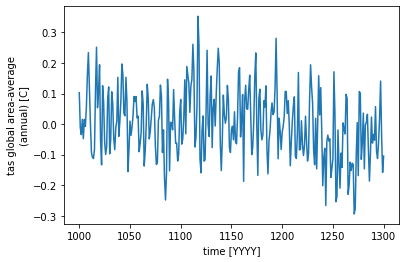

In [22]:
ccsm_tas_timeseries=ccsm.tas_global_avg_ann
print(ccsm_tas_timeseries.mean().values)
print(ccsm_tas_timeseries)
ccsm_tas_timeseries.plot()

In [4]:
cube_ccsm_tas_ann_timeseries = iris.load_cube('CCSM4_midHolocene.cvdp_data.1000-1300.nc', 'tas_global_avg_ann')

cube_ec_tas_ann_timeseries = iris.load_cube('EC-Earth3-LR_midHolocene.cvdp_data.2245-2445.nc', 'tas_global_avg_ann')

cube_fgoalsg2_tas_ann_timeseries = iris.load_cube('FGOALS-g2_midHolocene.cvdp_data.340-1019.nc', 'tas_global_avg_ann')

cube_giss_tas_ann_timeseries = iris.load_cube('GISS-E2-1-G_midHolocene.cvdp_data.2900-2999.nc', 'tas_global_avg_ann')

cube_hadgem_tas_ann_timeseries = iris.load_cube('HadGEM3-GC31-LL_midHolocene.cvdp_data.2250-2349.nc', 'tas_global_avg_ann')

cube_inm_tas_ann_timeseries = iris.load_cube('INM-CM4-8_midHolocene.cvdp_data.1880-2079.nc', 'tas_global_avg_ann')

cube_ipsl_tas_ann_timeseries = iris.load_cube('IPSL-CM6A-LR_midHolocene.cvdp_data.1850-2399.nc', 'tas_global_avg_ann')

cube_mpi2_tas_ann_timeseries = iris.load_cube('MPI-ESM1-2-LR_midHolocene.cvdp_data.1001-1500.nc', 'tas_global_avg_ann')

cube_mri_tas_ann_timeseries = iris.load_cube('MRI-ESM2-0_midHolocene.cvdp_data.1951-2150.nc', 'tas_global_avg_ann')

cube_mpip_tas_ann_timeseries = iris.load_cube('MPI-ESM-P_midHolocene.cvdp_data.1850-1949.nc', 'tas_global_avg_ann')

cube_mri3_tas_ann_timeseries = iris.load_cube('MRI-CGCM3_midHolocene.cvdp_data.1951-2050.nc', 'tas_global_avg_ann')

cube_noresm2_tas_ann_timeseries = iris.load_cube('NorESM2-LM_midHolocene.cvdp_data.2101-2200.nc', 'tas_global_avg_ann')



In [5]:
pi_cube_ccsm_tas_ann_timeseries = iris.load_cube('CCSM4_piControl.cvdp_data.250-1300.nc', 'tas_global_avg_ann')

pi_cube_ec_tas_ann_timeseries = iris.load_cube('EC-Earth3-LR_piControl.cvdp_data.2219-2419.nc', 'tas_global_avg_ann')

pi_cube_fgoalsg2_tas_ann_timeseries = iris.load_cube('FGOALS-g2_piControl.cvdp_data.201-900.nc', 'tas_global_avg_ann')

pi_cube_giss_tas_ann_timeseries = iris.load_cube('GISS-E2-1-G_piControl.cvdp_data.4150-5000.nc', 'tas_global_avg_ann')

pi_cube_hadgem_tas_ann_timeseries = iris.load_cube('HadGEM3-GC31-LL_piControl.cvdp_data.2250-2349.nc', 'tas_global_avg_ann')

pi_cube_inm_tas_ann_timeseries = iris.load_cube('INM-CM4-8_piControl.cvdp_data.1850-2380.nc', 'tas_global_avg_ann')

pi_cube_ipsl_tas_ann_timeseries = iris.load_cube('IPSL-CM6A-LR_piControl.cvdp_data.1850-3049.nc', 'tas_global_avg_ann')

pi_cube_mpi2_tas_ann_timeseries = iris.load_cube('MPI-ESM1-2-LR_piControl.cvdp_data.1850-2849.nc', 'tas_global_avg_ann')

pi_cube_mri_tas_ann_timeseries = iris.load_cube('MRI-ESM2-0_piControl.cvdp_data.1850-2550.nc', 'tas_global_avg_ann')

pi_cube_mpip_tas_ann_timeseries = iris.load_cube('MPI-ESM-P_piControl.cvdp_data.1850-3005.nc', 'tas_global_avg_ann')

pi_cube_mri3_tas_ann_timeseries = iris.load_cube('MRI-CGCM3_piControl.cvdp_data.1851-2350.nc', 'tas_global_avg_ann')

pi_cube_noresm2_tas_ann_timeseries = iris.load_cube('NorESM2-LM_piControl.cvdp_data.1710-2100.nc', 'tas_global_avg_ann')


In [19]:
cube_tas_ann_timeseries=[cube_ccsm_tas_ann_timeseries,  cube_ec_tas_ann_timeseries, 
                         cube_fgoalsg2_tas_ann_timeseries,  cube_giss_tas_ann_timeseries,  cube_hadgem_tas_ann_timeseries, 
                         cube_inm_tas_ann_timeseries,  cube_ipsl_tas_ann_timeseries,  cube_mpi2_tas_ann_timeseries, 
                         cube_mri_tas_ann_timeseries,  cube_mpip_tas_ann_timeseries,  cube_mri3_tas_ann_timeseries, 
                         cube_noresm2_tas_ann_timeseries]


In [20]:
pi_cube_tas_ann_timeseries=[pi_cube_ccsm_tas_ann_timeseries,  pi_cube_ec_tas_ann_timeseries, 
                            pi_cube_fgoalsg2_tas_ann_timeseries,  pi_cube_giss_tas_ann_timeseries,  pi_cube_hadgem_tas_ann_timeseries, 
                            pi_cube_inm_tas_ann_timeseries,  pi_cube_ipsl_tas_ann_timeseries,  pi_cube_mpi2_tas_ann_timeseries, 
                            pi_cube_mri_tas_ann_timeseries,  pi_cube_mpip_tas_ann_timeseries,  pi_cube_mri3_tas_ann_timeseries, 
                            pi_cube_noresm2_tas_ann_timeseries]


In [11]:
window = 51 #(50+1)

# construct 15-year low pass filters
# for the AMOC data which is annually
wgts15 = low_pass_weights(window, 1. / 15.)  


# apply the filters using the rolling_window method with the weights
# keyword argument
for j in range (0,len(cube_modelname)):
    globals()[cube_modelname[j]+'_amoc_fil'] = cube_amoc_ann[j].rolling_window('time',iris.analysis.MEAN,len(wgts15),weights=wgts15)


In [13]:
window = 51 #(50+1)

# construct 15-year low pass filters
# for the pi-AMOC data which is annually
wgts15 = low_pass_weights(window, 1. / 15.)  


# apply the filters using the rolling_window method with the weights
# keyword argument
for j in range (0,len(cube_modelname)):
    globals()['pi_'+ cube_modelname[j]+'_amoc_fil'] = pi_cube_amoc_ann[j].rolling_window('time',iris.analysis.MEAN,len(wgts15),weights=wgts15)

 

In [22]:
window = 51 #(50+1)

# construct 15-year low pass filters
# for the tas data which is annually
wgts15 = low_pass_weights(window, 1. / 15.)  


# apply the filters using the rolling_window method with the weights
# keyword argument
for j in range (0,len(cube_modelname)):
    globals()[cube_modelname[j]+'_tas_fil'] = cube_tas_ann_timeseries[j].rolling_window('time',iris.analysis.MEAN,len(wgts15),weights=wgts15)


In [23]:
window = 51 #(50+1)

# construct 15-year low pass filters
# for the pi_tas data which is annually
wgts15 = low_pass_weights(window, 1. / 15.)  


# apply the filters using the rolling_window method with the weights
# keyword argument
for j in range (0,len(cube_modelname)):
    globals()['pi_'+ cube_modelname[j]+'_tas_fil'] = pi_cube_tas_ann_timeseries[j].rolling_window('time',iris.analysis.MEAN,len(wgts15),weights=wgts15)


In [24]:
for j in range (0,len(cube_modelname)):
    globals()[cube_modelname[j]+'tas_amoc_timeseries_pearson_corr']=pearsonr(globals()[cube_modelname[j]+'_tas_fil'].data, globals()[cube_modelname[j]+'_amoc_fil'].data)

In [25]:
for j in range (0,len(cube_modelname)):
    globals()['pi_'+ cube_modelname[j]+'tas_amoc_timeseries_pearson_corr']=pearsonr(globals()['pi_'+ cube_modelname[j]+'_tas_fil'].data, globals()['pi_'+ cube_modelname[j]+'_amoc_fil'].data)

## plotting: AMOC (30N) and tas timeseries (Annual)  Pearson correlation coefficient in simulations (MH and PI)

[Text(0.5, 1.0, 'AMOC (30N) and tas timeseries (Annual) \n Pearson correlation coefficient in simulations (MH and PI)')]

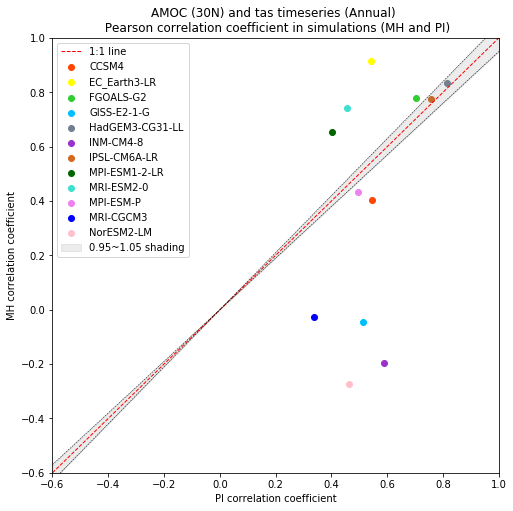

In [26]:
fig=plt.figure(figsize=(8,8)) 

ax=fig.add_subplot(111)

for k in range (0,len(cube_modelname)):
    ax.scatter(globals()['pi_'+ cube_modelname[k]+'tas_amoc_timeseries_pearson_corr'][0], globals()[cube_modelname[k]+'tas_amoc_timeseries_pearson_corr'][0], label=cube_model_name[k], color=cube_legend_color[k], marker='o')


x=np.linspace(-0.6,1,100)
y=x
ax.plot(x,y,'--',linewidth=1, color='r',label='1:1 line')
ax.plot(x,0.95*y, '--',linewidth=0.5, color='black')
ax.plot(x,1.05*y, '--',linewidth=0.5, color='black')
ax.fill_between(x, 0.95*y, 1.05*y, color='grey', alpha=0.15, label='0.95~1.05 shading')
ax.set(xlabel='PI correlation coefficient',ylabel='MH correlation coefficient')
ax.set_xlim(-0.6,1)
ax.set_ylim(-0.6,1)
ax.legend(loc='best')
ax.set(title='AMOC (30N) and tas timeseries (Annual) \n Pearson correlation coefficient in simulations (MH and PI)')

In [6]:
cube_ccsm_sst_ann_timeseries = iris.load_cube('CCSM4_midHolocene.cvdp_data.1000-1300.nc', 'sst_global_avg_ann')

cube_ec_sst_ann_timeseries = iris.load_cube('EC-Earth3-LR_midHolocene.cvdp_data.2245-2445.nc', 'sst_global_avg_ann')

cube_fgoalsg2_sst_ann_timeseries = iris.load_cube('FGOALS-g2_midHolocene.cvdp_data.340-1019.nc', 'sst_global_avg_ann')

cube_giss_sst_ann_timeseries = iris.load_cube('GISS-E2-1-G_midHolocene.cvdp_data.2900-2999.nc', 'sst_global_avg_ann')

cube_hadgem_sst_ann_timeseries = iris.load_cube('HadGEM3-GC31-LL_midHolocene.cvdp_data.2250-2349.nc', 'sst_global_avg_ann')

cube_inm_sst_ann_timeseries = iris.load_cube('INM-CM4-8_midHolocene.cvdp_data.1880-2079.nc', 'sst_global_avg_ann')

cube_ipsl_sst_ann_timeseries = iris.load_cube('IPSL-CM6A-LR_midHolocene.cvdp_data.1850-2399.nc', 'sst_global_avg_ann')

cube_mpi2_sst_ann_timeseries = iris.load_cube('MPI-ESM1-2-LR_midHolocene.cvdp_data.1001-1500.nc', 'sst_global_avg_ann')

cube_mri_sst_ann_timeseries = iris.load_cube('MRI-ESM2-0_midHolocene.cvdp_data.1951-2150.nc', 'sst_global_avg_ann')

cube_mpip_sst_ann_timeseries = iris.load_cube('MPI-ESM-P_midHolocene.cvdp_data.1850-1949.nc', 'sst_global_avg_ann')

cube_mri3_sst_ann_timeseries = iris.load_cube('MRI-CGCM3_midHolocene.cvdp_data.1951-2050.nc', 'sst_global_avg_ann')

cube_noresm2_sst_ann_timeseries = iris.load_cube('NorESM2-LM_midHolocene.cvdp_data.2101-2200.nc', 'sst_global_avg_ann')


In [7]:
pi_cube_ccsm_sst_ann_timeseries = iris.load_cube('CCSM4_piControl.cvdp_data.250-1300.nc', 'sst_global_avg_ann')

pi_cube_ec_sst_ann_timeseries = iris.load_cube('EC-Earth3-LR_piControl.cvdp_data.2219-2419.nc', 'sst_global_avg_ann')

pi_cube_fgoalsg2_sst_ann_timeseries = iris.load_cube('FGOALS-g2_piControl.cvdp_data.201-900.nc', 'sst_global_avg_ann')

pi_cube_giss_sst_ann_timeseries = iris.load_cube('GISS-E2-1-G_piControl.cvdp_data.4150-5000.nc', 'sst_global_avg_ann')

pi_cube_hadgem_sst_ann_timeseries = iris.load_cube('HadGEM3-GC31-LL_piControl.cvdp_data.2250-2349.nc', 'sst_global_avg_ann')

pi_cube_inm_sst_ann_timeseries = iris.load_cube('INM-CM4-8_piControl.cvdp_data.1850-2380.nc', 'sst_global_avg_ann')

pi_cube_ipsl_sst_ann_timeseries = iris.load_cube('IPSL-CM6A-LR_piControl.cvdp_data.1850-3049.nc', 'sst_global_avg_ann')

pi_cube_mpi2_sst_ann_timeseries = iris.load_cube('MPI-ESM1-2-LR_piControl.cvdp_data.1850-2849.nc', 'sst_global_avg_ann')

pi_cube_mri_sst_ann_timeseries = iris.load_cube('MRI-ESM2-0_piControl.cvdp_data.1850-2550.nc', 'sst_global_avg_ann')

pi_cube_mpip_sst_ann_timeseries = iris.load_cube('MPI-ESM-P_piControl.cvdp_data.1850-3005.nc', 'sst_global_avg_ann')

pi_cube_mri3_sst_ann_timeseries = iris.load_cube('MRI-CGCM3_piControl.cvdp_data.1851-2350.nc', 'sst_global_avg_ann')

pi_cube_noresm2_sst_ann_timeseries = iris.load_cube('NorESM2-LM_piControl.cvdp_data.1710-2100.nc', 'sst_global_avg_ann')


In [67]:
cube_sst_ann_timeseries=[cube_ccsm_sst_ann_timeseries,  cube_ec_sst_ann_timeseries, 
                         cube_fgoalsg2_sst_ann_timeseries,  cube_giss_sst_ann_timeseries,  cube_hadgem_sst_ann_timeseries, 
                         cube_inm_sst_ann_timeseries,  cube_ipsl_sst_ann_timeseries,  cube_mpi2_sst_ann_timeseries, 
                         cube_mri_sst_ann_timeseries,  cube_mpip_sst_ann_timeseries,  cube_mri3_sst_ann_timeseries, 
                         cube_noresm2_sst_ann_timeseries]


In [69]:
pi_cube_sst_ann_timeseries=[pi_cube_ccsm_sst_ann_timeseries,  pi_cube_ec_sst_ann_timeseries, 
                            pi_cube_fgoalsg2_sst_ann_timeseries,  pi_cube_giss_sst_ann_timeseries,  pi_cube_hadgem_sst_ann_timeseries, 
                            pi_cube_inm_sst_ann_timeseries,  pi_cube_ipsl_sst_ann_timeseries,  pi_cube_mpi2_sst_ann_timeseries, 
                            pi_cube_mri_sst_ann_timeseries,  pi_cube_mpip_sst_ann_timeseries,  pi_cube_mri3_sst_ann_timeseries, 
                            pi_cube_noresm2_sst_ann_timeseries]


In [70]:
window = 51 #(50+1)

# construct 15-year low pass filters
# for the sst data which is annually
wgts15 = low_pass_weights(window, 1. / 15.)  


# apply the filters using the rolling_window method with the weights
# keyword argument
for j in range (0,len(cube_modelname)):
    globals()[cube_modelname[j]+'_sst_fil'] = cube_sst_ann_timeseries[j].rolling_window('time',iris.analysis.MEAN,len(wgts15),weights=wgts15)


In [71]:
window = 51 #(50+1)

# construct 15-year low pass filters
# for the pi_sst data which is annually
wgts15 = low_pass_weights(window, 1. / 15.)  


# apply the filters using the rolling_window method with the weights
# keyword argument
for j in range (0,len(cube_modelname)):
    globals()['pi_'+ cube_modelname[j]+'_sst_fil'] = pi_cube_sst_ann_timeseries[j].rolling_window('time',iris.analysis.MEAN,len(wgts15),weights=wgts15)


In [72]:
for j in range (0,len(cube_modelname)):
    globals()[cube_modelname[j]+'sst_amoc_timeseries_pearson_corr']=pearsonr(globals()[cube_modelname[j]+'_sst_fil'].data, globals()[cube_modelname[j]+'_amoc_fil'].data)

In [73]:
for j in range (0,len(cube_modelname)):
    globals()['pi_'+ cube_modelname[j]+'sst_amoc_timeseries_pearson_corr']=pearsonr(globals()['pi_'+ cube_modelname[j]+'_sst_fil'].data, globals()['pi_'+ cube_modelname[j]+'_amoc_fil'].data)

## plotting: AMOC (30N) and tas timeseries (Annual)  Pearson correlation coefficient in simulations (MH and PI)

[Text(0.5, 1.0, 'AMOC (30N) and SST timeseries (Annual) \n Pearson correlation coefficient in simulations (MH and PI)')]

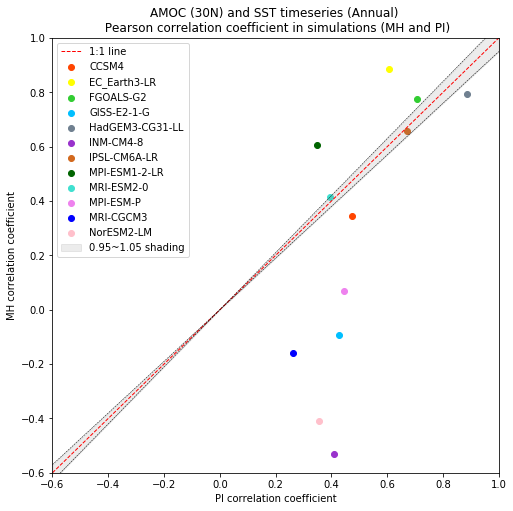

In [75]:
fig=plt.figure(figsize=(8,8)) 

ax=fig.add_subplot(111)

for k in range (0,len(cube_modelname)):
    ax.scatter(globals()['pi_'+ cube_modelname[k]+'sst_amoc_timeseries_pearson_corr'][0], globals()[cube_modelname[k]+'sst_amoc_timeseries_pearson_corr'][0], label=cube_model_name[k], color=cube_legend_color[k], marker='o')


x=np.linspace(-0.6,1,100)
y=x
ax.plot(x,y,'--',linewidth=1, color='r',label='1:1 line')
ax.plot(x,0.95*y, '--',linewidth=0.5, color='black')
ax.plot(x,1.05*y, '--',linewidth=0.5, color='black')
ax.fill_between(x, 0.95*y, 1.05*y, color='grey', alpha=0.15, label='0.95~1.05 shading')
ax.set(xlabel='PI correlation coefficient',ylabel='MH correlation coefficient')
ax.set_xlim(-0.6,1)
ax.set_ylim(-0.6,1)
ax.legend(loc='best')
ax.set(title='AMOC (30N) and SST timeseries (Annual) \n Pearson correlation coefficient in simulations (MH and PI)')